<a href="https://colab.research.google.com/github/Mugundankalyan/ecg_classifier/blob/main/dl1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import wfdb
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

record_list = ["100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
               "111", "112", "113", "114", "115", "116", "117", "118", "119",
               "121", "122", "123", "124", "200", "201", "202", "203", "205", "207",
               "208", "209", "210", "212", "213", "214", "215", "217", "219",
               "220", "221", "222", "223", "228", "230", "231", "232", "233", "234"]

def load_mitbih_data(record_list, window_size=100):
    X, y = [], []
    label_map = {"N": "Normal", "V": "PVC", "A": "APC", "L": "LBBB", "R": "RBBB"}

    for record in record_list:
        record_data = wfdb.rdsamp(f"/content/drive/MyDrive/Colab Notebooks/mit_data/mit-bih-arrhythmia-database-1.0.0/{record}")
        annotations = wfdb.rdann(f"/content/drive/MyDrive/Colab Notebooks/mit_data/mit-bih-arrhythmia-database-1.0.0/{record}", "atr")

        ecg_signal = record_data[0][:, 0]  # Lead I
        r_peaks = annotations.sample       # R-peak locations
        labels = annotations.symbol        # Arrhythmia labels

        scaler = StandardScaler()
        ecg_signal = scaler.fit_transform(ecg_signal.reshape(-1, 1)).flatten()

        # Extract beats
        for i, peak in enumerate(r_peaks):
            if peak - window_size//2 > 0 and peak + window_size//2 < len(ecg_signal):
                beat = ecg_signal[peak - window_size//2 : peak + window_size//2]
                if labels[i] in label_map:
                    X.append(beat)
                    y.append(label_map[labels[i]])

    return np.array(X), np.array(y)

X, y = load_mitbih_data(record_list)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X = X.reshape(X.shape[0], X.shape[1], 1)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)

    return x + res

def build_transformer(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

input_shape = (100, 1)
num_classes = y_categorical.shape[1]
model = build_transformer(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 100, 1)         │          1,793 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 100, 1)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 100, 1)         │              2 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 100, 1)         │              0 │ layer_normalization[0… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 100, 128)       │            256 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 100, 128)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 100, 128)       │            256 │ dropout_2[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 100, 128)       │              0 │ layer_normalization_1… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 100, 128)       │        131,968 │ add_1[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 100, 128)       │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 100, 128)       │            256 │ dropout_4[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 100, 128)       │              0 │ layer_normalization_2… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100, 128)       │         16,512 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 100, 128)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3

 Total params: 159,880 (624.53 KB)

 Trainable params: 159,880 (624.53 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.7858 - loss: 0.6742 - val_accuracy: 0.8545 - val_loss: 0.4416
Epoch 2/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.8677 - loss: 0.4395 - val_accuracy: 0.8996 - val_loss: 0.3381
Epoch 3/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.8789 - loss: 0.4035 - val_accuracy: 0.8748 - val_loss: 0.3837
Epoch 4/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8853 - loss: 0.3797 - val_accuracy: 0.9031 - val_loss: 0.3312
Epoch 5/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8909 - loss: 0.3710 - val_accuracy: 0.9093 - val_loss: 0.3148
Epoch 6/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8939 - loss: 0.3548 - val_accuracy: 0.9132 - val_loss: 0.2938
Epoch 7/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8953 - loss: 0.3429 - val_accuracy: 0.9165 - val_loss: 0.2827
Epoch 8/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9002 - loss: 

626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9229 - loss: 0.2606
Test Accuracy: 92.22%


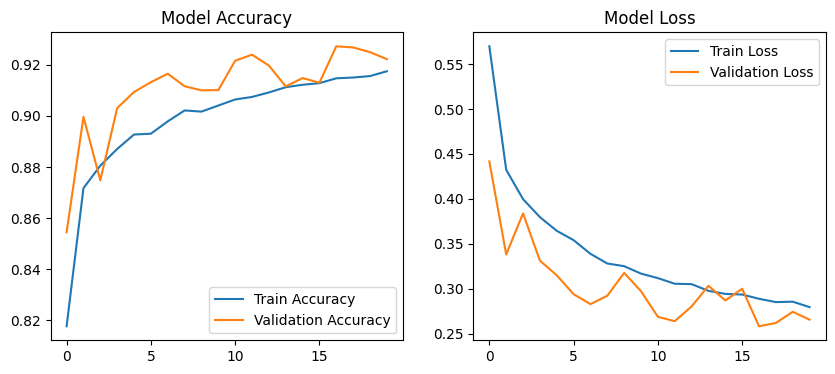

In [7]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss")
plt.show()


In [8]:
model.save("ecg_transformer_model.keras")

In [9]:
from tensorflow.keras.models import load_model

model = load_model("ecg_transformer_model.keras")

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


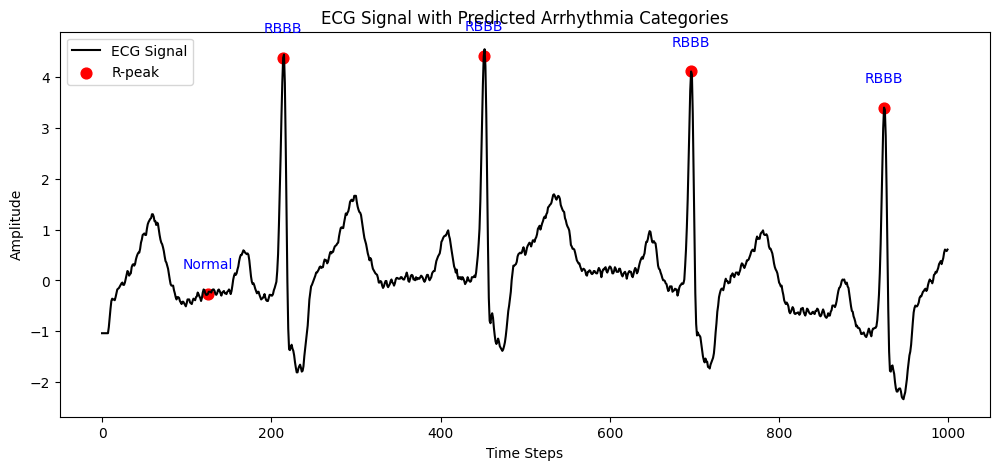

In [10]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

model = load_model("ecg_transformer_model.keras")

record_name = "212"
record_path = f"/content/drive/MyDrive/Colab Notebooks/mit_data/mit-bih-arrhythmia-database-1.0.0/{record_name}"

# Load ECG signal and annotations
record = wfdb.rdsamp(record_path)
annotations = wfdb.rdann(record_path, "atr")

ecg_signal = record[0][:, 0]

r_peaks = annotations.sample

scaler = StandardScaler()
ecg_signal = scaler.fit_transform(ecg_signal.reshape(-1, 1)).flatten()

window_size = 100
X_input = []
peak_indices = []

for peak in r_peaks:
    if peak - window_size//2 > 0 and peak + window_size//2 < len(ecg_signal):
        beat = ecg_signal[peak - window_size//2 : peak + window_size//2]
        X_input.append(beat)
        peak_indices.append(peak)

X_input = np.array(X_input).reshape(len(X_input), window_size, 1)

y_pred_probs = model.predict(X_input)

predicted_indices = np.argmax(y_pred_probs, axis=1)

encoder = LabelEncoder()
encoder.classes_ = np.array(["APC", "PVC","Normal", "LBBB", "RBBB"])

predicted_labels = encoder.inverse_transform(predicted_indices)

def plot_ecg_with_labels(ecg_signal, r_peaks, predicted_labels, num_samples=1000):
    plt.figure(figsize=(12, 5))
    plt.plot(ecg_signal[:num_samples], label="ECG Signal", color="black")

    for i, peak in enumerate(r_peaks):
        if peak < num_samples:
            plt.scatter(peak, ecg_signal[peak], color="red", s=60, label="R-peak" if i == 0 else "")
            plt.text(peak, ecg_signal[peak] + 0.5, predicted_labels[i], color="blue", fontsize=10, ha="center")

    plt.title("ECG Signal with Predicted Arrhythmia Categories")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

plot_ecg_with_labels(ecg_signal, peak_indices, predicted_labels, num_samples=1000)
